# **Colpali based RAG on State of AI - 2024 report using Qdrant**

In this notebook, we'll explore [ColPali]((https://arxiv.org/abs/2407.01449)), a groundbreaking approach to document retrieval that harnesses the power of Vision Language Models (VLMs) to revolutionize how we process and search through complex documents.

ColPali is an innovative multimodal retrieval system designed to replace traditional document retrievers. Unlike conventional methods that rely heavily on Optical Character Recognition (OCR) and complex data ingestion pipelines, ColPali takes an end-to-end multimodal approach.

The key features include : 
- *Visual Content Understanding:* ColPali processes entire document pages as images, allowing it to capture not just text, but also visual elements like tables, figures, and layout13.
- *Efficient Indexing:* By eliminating the need for OCR and complex preprocessing, ColPali significantly reduces indexing time and complexity12.
- *Improved Retrieval Accuracy:* The use of Vision Language Models enables ColPali to understand documents more holistically, leading to better retrieval performance

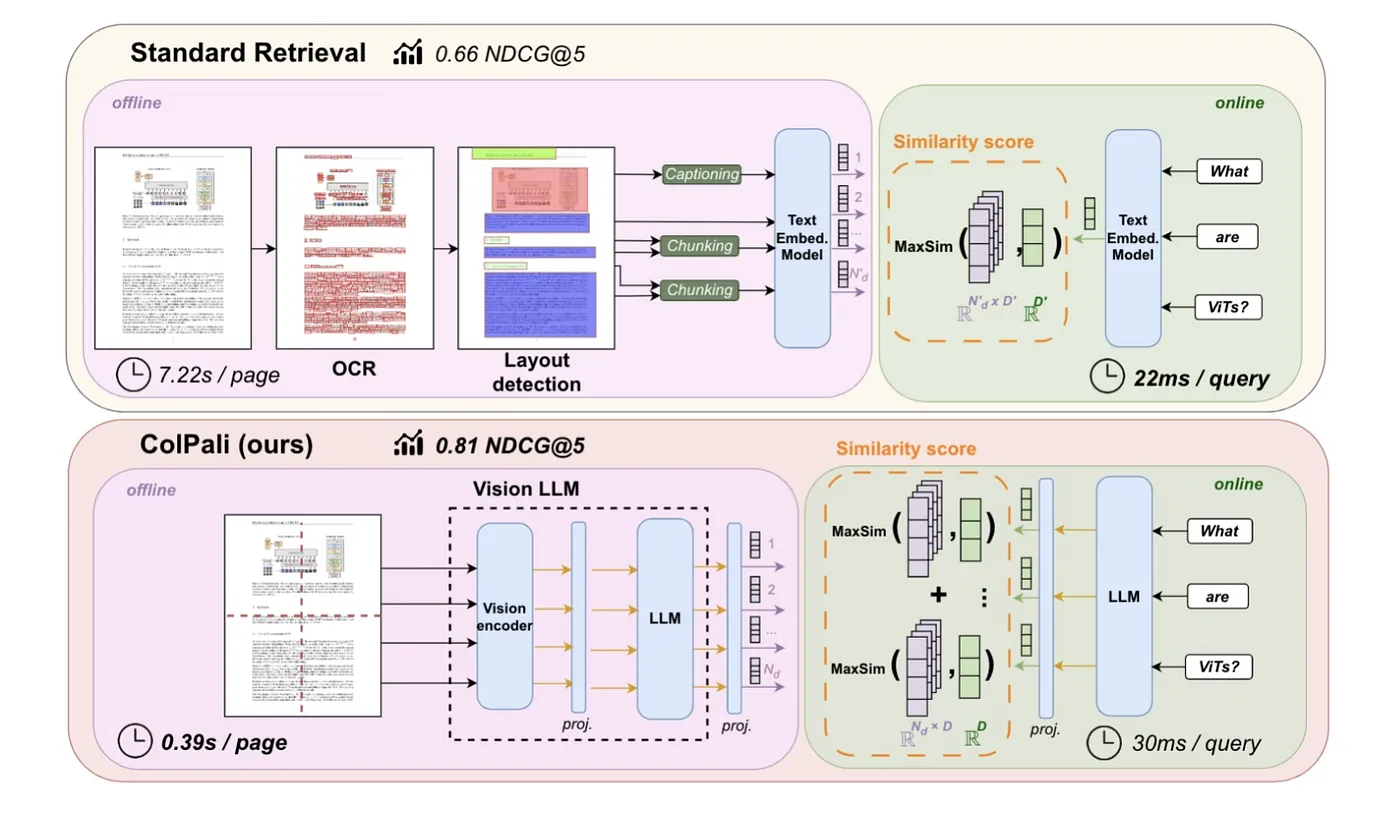

We leverage and showcase [Qdrant's](https://qdrant.tech/) [multivector](https://qdrant.tech/documentation/concepts/vectors/#multivectors) features in this notebook.

*More details* - [paper](https://arxiv.org/abs/2407.01449)

***Note of Thanks to https://danielvanstrien.xyz/posts/post-with-code/colpali-qdrant/2024-10-02_using_colpali_with_qdrant.html for the inital implementation idea.***

In [3]:
## Installations

#!pip install uv
#!uv pip install --system colpali_engine>=0.3.1 datasets huggingface_hub[hf_transfer] qdrant-client transformers>=4.45.0 stamina rich

In [7]:
##Imports

import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from typing import cast
from datasets import load_dataset
from qdrant_client import QdrantClient
from qdrant_client.http import models
from colpali_engine.models import ColPali, ColPaliProcessor

In [8]:
## To enable faster downloads

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [9]:
## Setting up the ColPali model

model_name = "vidore/colpali-v1.2"

model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="mps",  # or "mps" if on Apple Silicon
).eval()

processor = ColPaliProcessor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
## Bring the dataset for state of ai 2024 (https://huggingface.co/datasets/atitaarora/state-of-ai-2024) report as images

dataset = load_dataset("atitaarora/state-of-ai-2024", split="train")

README.md:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/212 [00:00<?, ?it/s]

(…)ate of AI Report - 2024.pdf_page_110.jpg:   0%|          | 0.00/50.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_107.jpg:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_100.jpg:   0%|          | 0.00/85.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_104.jpg:   0%|          | 0.00/88.7k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_102.jpg:   0%|          | 0.00/92.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_112.jpg:   0%|          | 0.00/68.7k [00:00<?, ?B/s]

State of AI Report - 2024.pdf_page_1.jpg:   0%|          | 0.00/26.6k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_108.jpg:   0%|          | 0.00/57.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_103.jpg:   0%|          | 0.00/74.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_11.jpg:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_111.jpg:   0%|          | 0.00/62.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_106.jpg:   0%|          | 0.00/41.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_113.jpg:   0%|          | 0.00/81.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_10.jpg:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_105.jpg:   0%|          | 0.00/46.5k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_115.jpg:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_109.jpg:   0%|          | 0.00/41.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_116.jpg:   0%|          | 0.00/87.2k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_12.jpg:   0%|          | 0.00/87.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_118.jpg:   0%|          | 0.00/91.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_122.jpg:   0%|          | 0.00/92.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_117.jpg:   0%|          | 0.00/62.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_114.jpg:   0%|          | 0.00/78.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_101.jpg:   0%|          | 0.00/89.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_121.jpg:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_120.jpg:   0%|          | 0.00/91.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_119.jpg:   0%|          | 0.00/84.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_124.jpg:   0%|          | 0.00/73.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_123.jpg:   0%|          | 0.00/87.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_127.jpg:   0%|          | 0.00/67.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_132.jpg:   0%|          | 0.00/58.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_129.jpg:   0%|          | 0.00/62.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_13.jpg:   0%|          | 0.00/85.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_125.jpg:   0%|          | 0.00/86.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_128.jpg:   0%|          | 0.00/90.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_126.jpg:   0%|          | 0.00/71.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_130.jpg:   0%|          | 0.00/83.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_134.jpg:   0%|          | 0.00/82.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_136.jpg:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_131.jpg:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_133.jpg:   0%|          | 0.00/59.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_139.jpg:   0%|          | 0.00/67.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_138.jpg:   0%|          | 0.00/79.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_135.jpg:   0%|          | 0.00/79.3k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_14.jpg:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_141.jpg:   0%|          | 0.00/65.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_137.jpg:   0%|          | 0.00/70.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_140.jpg:   0%|          | 0.00/85.5k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_142.jpg:   0%|          | 0.00/66.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_144.jpg:   0%|          | 0.00/96.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_143.jpg:   0%|          | 0.00/83.7k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_145.jpg:   0%|          | 0.00/75.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_146.jpg:   0%|          | 0.00/77.5k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_150.jpg:   0%|          | 0.00/51.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_151.jpg:   0%|          | 0.00/50.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_149.jpg:   0%|          | 0.00/49.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_15.jpg:   0%|          | 0.00/91.6k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_147.jpg:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_153.jpg:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_152.jpg:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_157.jpg:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_155.jpg:   0%|          | 0.00/93.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_154.jpg:   0%|          | 0.00/90.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_148.jpg:   0%|          | 0.00/46.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_16.jpg:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_163.jpg:   0%|          | 0.00/64.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_162.jpg:   0%|          | 0.00/90.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_160.jpg:   0%|          | 0.00/85.7k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_158.jpg:   0%|          | 0.00/83.1k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_165.jpg:   0%|          | 0.00/87.6k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_164.jpg:   0%|          | 0.00/87.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_156.jpg:   0%|          | 0.00/82.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_161.jpg:   0%|          | 0.00/86.7k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_159.jpg:   0%|          | 0.00/84.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_17.jpg:   0%|          | 0.00/72.7k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_166.jpg:   0%|          | 0.00/90.5k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_167.jpg:   0%|          | 0.00/80.7k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_170.jpg:   0%|          | 0.00/84.5k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_169.jpg:   0%|          | 0.00/89.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_174.jpg:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_171.jpg:   0%|          | 0.00/100k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_172.jpg:   0%|          | 0.00/85.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_168.jpg:   0%|          | 0.00/88.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_175.jpg:   0%|          | 0.00/57.7k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_173.jpg:   0%|          | 0.00/83.5k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_179.jpg:   0%|          | 0.00/75.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_180.jpg:   0%|          | 0.00/87.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_177.jpg:   0%|          | 0.00/88.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_181.jpg:   0%|          | 0.00/103k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_178.jpg:   0%|          | 0.00/81.3k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_18.jpg:   0%|          | 0.00/93.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_183.jpg:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_176.jpg:   0%|          | 0.00/92.5k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_184.jpg:   0%|          | 0.00/78.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_185.jpg:   0%|          | 0.00/94.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_187.jpg:   0%|          | 0.00/85.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_186.jpg:   0%|          | 0.00/89.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_189.jpg:   0%|          | 0.00/85.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_188.jpg:   0%|          | 0.00/85.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_191.jpg:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_194.jpg:   0%|          | 0.00/70.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_192.jpg:   0%|          | 0.00/80.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_182.jpg:   0%|          | 0.00/77.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_197.jpg:   0%|          | 0.00/73.1k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_196.jpg:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_195.jpg:   0%|          | 0.00/78.5k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_19.jpg:   0%|          | 0.00/83.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_193.jpg:   0%|          | 0.00/83.1k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_190.jpg:   0%|          | 0.00/83.0k [00:00<?, ?B/s]

State of AI Report - 2024.pdf_page_2.jpg:   0%|          | 0.00/36.4k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_198.jpg:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_20.jpg:   0%|          | 0.00/78.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_204.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_202.jpg:   0%|          | 0.00/80.9k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_199.jpg:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_201.jpg:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_200.jpg:   0%|          | 0.00/72.6k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_208.jpg:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_207.jpg:   0%|          | 0.00/29.2k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_206.jpg:   0%|          | 0.00/63.0k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_209.jpg:   0%|          | 0.00/36.5k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_210.jpg:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_211.jpg:   0%|          | 0.00/50.3k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_203.jpg:   0%|          | 0.00/79.5k [00:00<?, ?B/s]

(…)ate of AI Report - 2024.pdf_page_205.jpg:   0%|          | 0.00/72.3k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_22.jpg:   0%|          | 0.00/88.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_24.jpg:   0%|          | 0.00/80.0k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_25.jpg:   0%|          | 0.00/85.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_21.jpg:   0%|          | 0.00/84.6k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_23.jpg:   0%|          | 0.00/89.5k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_27.jpg:   0%|          | 0.00/88.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_28.jpg:   0%|          | 0.00/38.3k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_30.jpg:   0%|          | 0.00/81.6k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_31.jpg:   0%|          | 0.00/82.6k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_29.jpg:   0%|          | 0.00/89.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_33.jpg:   0%|          | 0.00/76.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_26.jpg:   0%|          | 0.00/82.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_35.jpg:   0%|          | 0.00/81.9k [00:00<?, ?B/s]

State of AI Report - 2024.pdf_page_3.jpg:   0%|          | 0.00/35.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_34.jpg:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

State of AI Report - 2024.pdf_page_4.jpg:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_39.jpg:   0%|          | 0.00/66.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_36.jpg:   0%|          | 0.00/87.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_37.jpg:   0%|          | 0.00/82.8k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_40.jpg:   0%|          | 0.00/89.7k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_38.jpg:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_32.jpg:   0%|          | 0.00/77.5k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_41.jpg:   0%|          | 0.00/86.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_42.jpg:   0%|          | 0.00/88.3k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_43.jpg:   0%|          | 0.00/89.7k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_44.jpg:   0%|          | 0.00/65.2k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_45.jpg:   0%|          | 0.00/75.5k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_46.jpg:   0%|          | 0.00/81.8k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_47.jpg:   0%|          | 0.00/78.5k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_50.jpg:   0%|          | 0.00/95.1k [00:00<?, ?B/s]

State of AI Report - 2024.pdf_page_5.jpg:   0%|          | 0.00/76.7k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_51.jpg:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_49.jpg:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_55.jpg:   0%|          | 0.00/99.6k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_48.jpg:   0%|          | 0.00/95.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_52.jpg:   0%|          | 0.00/93.0k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_53.jpg:   0%|          | 0.00/94.5k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_56.jpg:   0%|          | 0.00/78.7k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_58.jpg:   0%|          | 0.00/87.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_57.jpg:   0%|          | 0.00/76.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_54.jpg:   0%|          | 0.00/74.8k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_59.jpg:   0%|          | 0.00/96.9k [00:00<?, ?B/s]

State of AI Report - 2024.pdf_page_6.jpg:   0%|          | 0.00/82.0k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_60.jpg:   0%|          | 0.00/91.5k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_61.jpg:   0%|          | 0.00/79.6k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_65.jpg:   0%|          | 0.00/79.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_68.jpg:   0%|          | 0.00/67.2k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_64.jpg:   0%|          | 0.00/74.8k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_66.jpg:   0%|          | 0.00/71.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_70.jpg:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

State of AI Report - 2024.pdf_page_7.jpg:   0%|          | 0.00/41.2k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_69.jpg:   0%|          | 0.00/85.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_67.jpg:   0%|          | 0.00/91.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_62.jpg:   0%|          | 0.00/89.5k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_63.jpg:   0%|          | 0.00/76.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_71.jpg:   0%|          | 0.00/72.0k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_73.jpg:   0%|          | 0.00/57.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_72.jpg:   0%|          | 0.00/87.8k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_75.jpg:   0%|          | 0.00/64.8k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_74.jpg:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_78.jpg:   0%|          | 0.00/91.7k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_77.jpg:   0%|          | 0.00/85.0k [00:00<?, ?B/s]

State of AI Report - 2024.pdf_page_8.jpg:   0%|          | 0.00/82.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_81.jpg:   0%|          | 0.00/77.6k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_79.jpg:   0%|          | 0.00/78.7k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_84.jpg:   0%|          | 0.00/53.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_76.jpg:   0%|          | 0.00/88.2k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_86.jpg:   0%|          | 0.00/53.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_85.jpg:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_82.jpg:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_80.jpg:   0%|          | 0.00/83.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_83.jpg:   0%|          | 0.00/85.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_87.jpg:   0%|          | 0.00/75.0k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_88.jpg:   0%|          | 0.00/58.0k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_89.jpg:   0%|          | 0.00/53.6k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_90.jpg:   0%|          | 0.00/63.8k [00:00<?, ?B/s]

State of AI Report - 2024.pdf_page_9.jpg:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_93.jpg:   0%|          | 0.00/58.5k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_95.jpg:   0%|          | 0.00/54.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_91.jpg:   0%|          | 0.00/44.8k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_92.jpg:   0%|          | 0.00/61.8k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_96.jpg:   0%|          | 0.00/60.4k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_94.jpg:   0%|          | 0.00/50.2k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_98.jpg:   0%|          | 0.00/59.9k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_97.jpg:   0%|          | 0.00/89.1k [00:00<?, ?B/s]

(…)tate of AI Report - 2024.pdf_page_99.jpg:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/212 [00:00<?, ? examples/s]

In [11]:
## dataset info
dataset

Dataset({
    features: ['image'],
    num_rows: 212
})

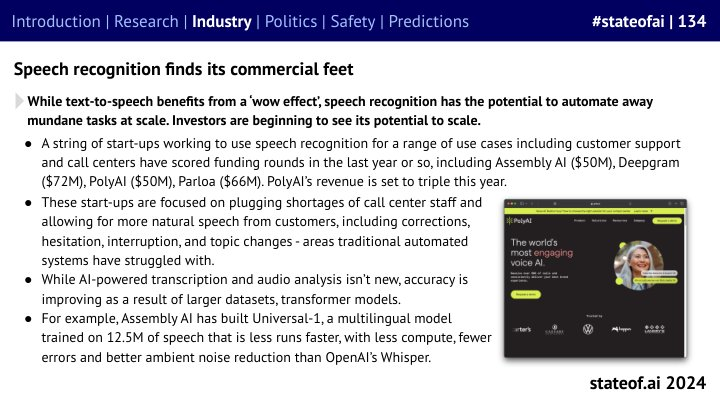

In [12]:
## random selection of the page from the dataset to see what it looks like
dataset[39]["image"]

In [13]:
## Setting Qdrant in memory
qdrant_client = QdrantClient(
    ":memory:"
)  # Use ":memory:" for in-memory database or "path/to/db" for persistent storage


In [14]:
## Collection name to use throughout the notebook
collection_name = "colpali-state-of-ai"

In [15]:
## General Collection level operations

## Get information about existing collections 
#qdrant_client.get_collections()

## Get information about specific collection
#collection_info = qdrant_client.get_collection(collection_name)
#print(collection_info)

## Deleting collection, if need be
#qdrant_client.delete_collection(collection_name)

In [16]:
## Setting up the ColPali model
## From https://huggingface.co/vidore/colpali
## ColPali: Visual Retriever based on PaliGemma-3B with ColBERT strategy

from colpali_engine.models import ColPali, ColPaliProcessor

# Initialize ColPali model and processor
model_name = (
    "vidore/colpali-v1.2"  # Use the latest version available
)
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="mps",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
)
colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpaligemma-3b-pt-448-base"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Multivector in Qdrant - https://qdrant.tech/documentation/concepts/vectors/#multivectors
To use multivectors in Qdrant, we need to specify the dimensions of the vectors.
So, in order to use multivectors, we need to specify their length. We can check this by passing in an example image to the model and checking the shape of the output.

In [17]:

sample_image = dataset[0]["image"]
with torch.no_grad():
    sample_batch = colpali_processor.process_images([sample_image]).to(
        colpali_model.device
    )
    sample_embedding = colpali_model(**sample_batch)

In [18]:
sample_embedding

tensor([[[-0.1201,  0.1445,  0.2832,  ...,  0.0625, -0.0854,  0.0017],
         [-0.0869,  0.1582,  0.2080,  ...,  0.0640, -0.0996, -0.0107],
         [ 0.0175,  0.1147,  0.1973,  ...,  0.1143,  0.0233,  0.0127],
         ...,
         [-0.0977,  0.0117,  0.1230,  ...,  0.0388, -0.0071,  0.1367],
         [-0.1245, -0.0146,  0.2051,  ...,  0.0044, -0.0737,  0.1299],
         [-0.0840,  0.1514,  0.2793,  ...,  0.0581, -0.1328, -0.0020]]],
       device='mps:0', dtype=torch.bfloat16)

In [19]:
sample_embedding.shape

torch.Size([1, 1030, 128])

In [20]:
## determining the length of the vectors for collection configuration.
vector_size = sample_embedding.shape[2]
vector_size

128

In [21]:
## Create a collection in Qdrant with a multivector configuration with 
## Quantization(process to convert the vectors to 8-bit integers, reducing the memory footprint and speeding up the search)
## Also added always_ram = True to keep the vectors in RAM which will increase performance at the cost of memory usage.

qdrant_client.create_collection(
    collection_name=collection_name,  # the name of the collection
    on_disk_payload=True,  # store the payload on disk
    optimizers_config=models.OptimizersConfigDiff(indexing_threshold=0),
    vectors_config=models.VectorParams(
        size=vector_size,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.ScalarQuantization(
            scalar=models.ScalarQuantizationConfig(
                type=models.ScalarType.INT8,
                quantile=0.99,
                always_ram=True,
            ),
        ),
    ),
)

True

In [22]:
## Helper fucntion to uploading the vectors to Qdrant
## Using Stamina - https://github.com/hynek/stamina to enable production-grade retires in Python
import stamina


@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(batch):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

In [23]:
## Vector creation and ingesting them into Qdrant

batch_size = 4  # Adjust based on your GPU memory constraints

# Use tqdm to create a progress bar
with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]

        # The images are already PIL Image objects, so we can use them directly
        images = batch["image"]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(
                colpali_model.device
            )
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            # Convert the embedding to a list of vectors
            multivector = embedding.cpu().float().numpy().tolist()
            points.append(
                models.PointStruct(
                    id=i + j,  # we just use the index as the ID
                    vector=multivector,  # This is now a list of vectors
                    payload={
                        "source": "internet archive"
                    },  # can also add other metadata/data
                )
            )
        # Upload points to Qdrant
        try:
            upsert_to_qdrant(points)
        # clown level error handling here 🤡
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(batch_size)

print("Indexing complete!")

Indexing Progress: 100%|█████████████████████████████████████████████████████████| 212/212 [19:50<00:00,  5.61s/it]

Indexing complete!


In [24]:
## For efficiency - https://qdrant.tech/documentation/tutorials/bulk-upload/#disable-indexing-during-upload

qdrant_client.update_collection(
    collection_name=collection_name,
    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
)

False

In [25]:
## Checking the indexed vectors
qdrant_client.scroll(collection_name=collection_name, limit=10)

([Record(id=0, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=1, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=2, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=3, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=4, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=5, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=6, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=7, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=8, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=9, payload={'source': 'internet archive'}, vector=None, shard

### Search 101 using Multivector in Qdrant

In [26]:
## Query embedding processing
query_text = "what is the process of shrinking the memory requirements of LLM by reducing the precision of their parameters called?"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
query_embedding

tensor([[[ 1.6406e-01, -2.0020e-02,  9.8145e-02,  ..., -3.1738e-02,
          -7.7148e-02, -2.5391e-02],
         [-1.1279e-01, -1.2891e-01,  5.1514e-02,  ..., -1.2573e-02,
          -1.1133e-01,  1.2402e-01],
         [-1.6992e-01, -1.9043e-01,  1.1426e-01,  ..., -8.7280e-03,
          -7.7148e-02,  9.2773e-02],
         ...,
         [ 3.5048e-05, -1.5723e-01,  8.6426e-02,  ..., -4.8584e-02,
           4.6875e-02, -5.7129e-02],
         [-2.4292e-02, -1.4648e-01,  2.0508e-02,  ..., -1.2451e-01,
           7.1289e-02,  3.1494e-02],
         [-9.4238e-02, -6.5918e-02,  6.7383e-02,  ..., -1.7188e-01,
           3.9551e-02,  7.8613e-02]]], device='mps:0', dtype=torch.bfloat16)

In [27]:
query_embedding[0].shape

torch.Size([35, 128])

In [28]:
# Convert the query embedding to a list of vectors
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [29]:
# Search in Qdrant
search_result = qdrant_client.query_points(
    collection_name=collection_name, query=multivector_query, limit=2, timeout=60
)

search_result.points

[ScoredPoint(id=129, version=0, score=24.091031993583332, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=143, version=0, score=19.29314039185301, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None)]

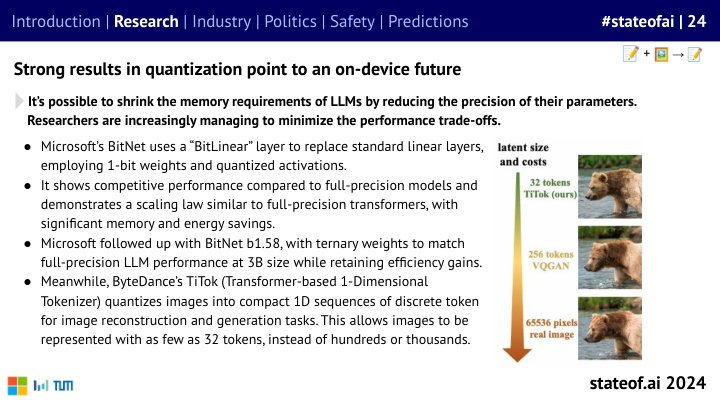

In [30]:
## Inspecting the image returned corresponding to the vector
idx = search_result.points[0].id
dataset[idx]["image"]

### Modularise the `search-image-by-text` and `search-by-text-and-return-images` process for smoother transition into building RAG

In [32]:
def search_images_by_text(query_text, top_k=2):
    # Process and encode the text query
    with torch.no_grad():
        batch_query = colpali_processor.process_queries([query_text]).to(
            colpali_model.device
        )
        query_embedding = colpali_model(**batch_query)

    # Convert the query embedding to a list of vectors
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    # Search in Qdrant
    search_result = qdrant_client.query_points(
        collection_name=collection_name, query=multivector_query, limit=top_k
    )

    return search_result

def search_by_text_and_return_images(query_text, top_k=2):
    results = search_images_by_text(query_text, top_k)
    row_ids = [r.id for r in results.points]
    return dataset.select(row_ids)

In [33]:
# Example vector retrieval request
query_text = "What is state of RAG evaluation from the given report?"
results = search_images_by_text(query_text)

for result in results.points:
    print(result)

id=140 version=0 score=16.552075874373255 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=138 version=0 score=14.311785598000021 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None


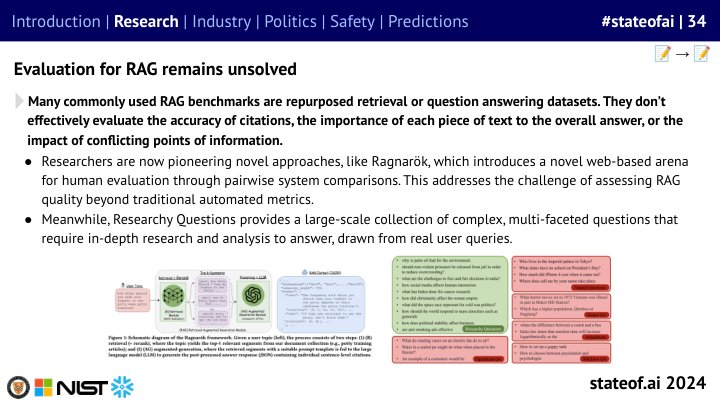

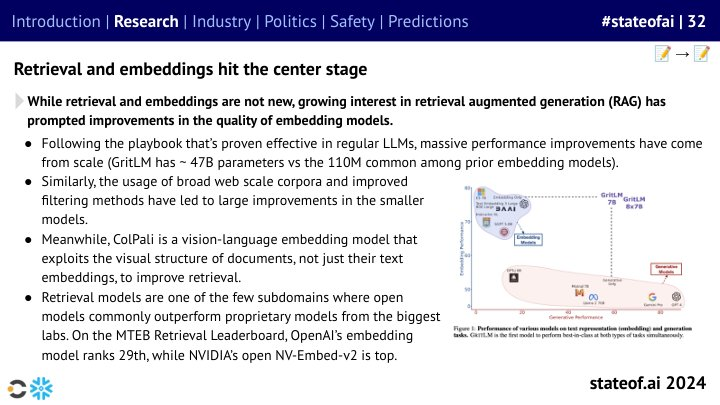

In [34]:
# Example image retrieval request
results_ds = search_by_text_and_return_images(query_text)

for row in results_ds:
    # display image
    display(row["image"])

### Lets build Multimodal RAG using Colpali using OpenAI

In [35]:
#!pip install openai

In [36]:
# OpenAI API Key
OPENAI_API_KEY= os.getenv("OPENAI_API_KEY")

#### Bringing it all together 

In [37]:
from openai import OpenAI
import base64
from io import BytesIO

client = OpenAI(api_key=OPENAI_API_KEY)


# Function to encode an image to base64
def encode_image(image_obj):
    buffered = BytesIO()
    image_obj.save(buffered, format="JPEG")  # Adjust format as needed
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

# process the retrieved images for response generation
def process_images_for_query_response(query_text):

    # Assuming this method returns a list of dictionaries with an 'image' key containing PIL image objects.
    results_ds = search_by_text_and_return_images(query_text)
    
    # Encode all images from the result set
    encoded_images = [
        f"data:image/jpeg;base64,{encode_image(result['image'])}" for result in results_ds
    ]
    
    # Create message content with text and images
    content = [{"type": "text", "text": query_text}] + [
        {"type": "image_url", "image_url": {"url": image_url}} for image_url in encoded_images
    ]
    
    # Send the request to the API
    response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[
        {
          "role": "user",
          "content": content,
        }
      ],
      max_tokens=300,
    )
    
    print(response.choices[0].message.content)


### Question 1 - What is state of RAG evaluation from the given report?

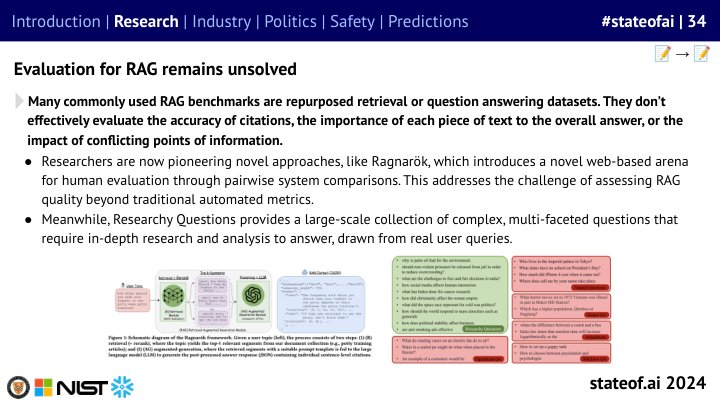

In [46]:
## Query to test retrieval
query_text = "What is state of RAG evaluation from the given report?"
search_by_text_and_return_images(query_text,top_k=2)[0]['image']

In [38]:
## Let's test the response generation
process_images_for_query_response(query_text)

The evaluation of Retrieval-Augmented Generation (RAG) remains an unresolved challenge, according to the report. Key points from the evaluation state include:

1. **Ineffective Benchmarks**: Many traditional benchmarks used for RAG are taken from existing retrieval or question-answering datasets, failing to adequately assess citation accuracy and the relevance of each source contributing to the overall answer. They also do not effectively address conflicting information from multiple sources.

2. **Novel Approaches**: Researchers are exploring new methods, such as the Ragnarök system, which offers a web-based platform for pairwise comparison of responses. This aims to assess RAG quality more comprehensively than conventional automated metrics can.

3. **Research Complexity**: The report emphasizes the need for in-depth research questions that reflect real user queries. This complexity necessitates a more nuanced analysis to evaluate RAG capabilities effectively.

Overall, the landscape

### Question 2 -  What were the root causes of interupions during Llama 3 405B pretraining?
Note so obvious question as it involves Summarisation of the pie chart

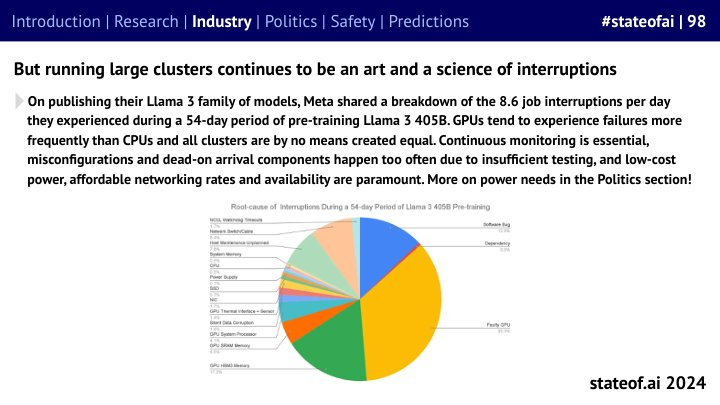

In [51]:
query_text_3 = "what were the root causes of interupions during Llama 3 405B pretraining?" 
search_by_text_and_return_images(query_text_3,top_k=2)[0]['image']
#process_images_for_query_response(query_text_3)

In [52]:
process_images_for_query_response(query_text_3)

The interruptions during the pretraining of Llama 3 405B were primarily caused by a variety of technical issues related to the use of large GPU clusters. Here are the root causes highlighted:

1. **Hardware Failures**: GPUs tend to experience failures more frequently than CPUs.
2. **Cluster Inequalities**: Not all clusters are equal, leading to variable performance and reliability across different setups.
3. **Continuous Monitoring Needs**: Continuous monitoring is essential to identify and rectify issues promptly.
4. **Misconfigurations**: Common misconfigurations can lead to significant downtime.
5. **Arrival of Components**: Delays and failure in the arrival of necessary hardware components often lead to interruptions.
6. **Power Supply Issues**: Low-cost power management strategies sometimes resulted in unreliable power supply.

These factors combined contributed to an average of 8.6 job interruptions per day during the pretraining phase.


### Conclusions

I have been pleasantly surprised as well as amazed at the capabilities of Colpali. Having worked with many applications involving complex
PDF structures parsing and synthesising the images as well as text information at the same time for response generation , I am very positive for the possibilities this approach may bring to the upcoming RAG applications.

Excited !!!